Retinal Vessel Extraction — Sauvola vs Niblack
Task: Extract thin vessels in fundus images

Methods: Niblack vs Sauvola thresholding

Dataset: Kaggle — DRIVE retinal dataset mirrors

Compare: Sensitivity for thin vessels

Learning: Local threshold behavior on thin structures

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import remove_small_objects, skeletonize
from sklearn.metrics import confusion_matrix

In [ ]:
def load_pair(filename):
    img_path = os.path.join(image_dir, filename)

    # build correct mask name
    name = filename.split('.')[0]
    mask_name = name + "_mask.gif"

    mask_path = os.path.join(mask_dir, mask_name)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    if mask is None:
        raise FileNotFoundError(f"Mask not found: {mask_path}")

    mask = mask > 0   # convert to binary
    return img, mask

Total test images: 20


In [13]:
def load_pair(filename):
    img_path = os.path.join(image_dir, filename)

    # build correct mask name
    name = filename.split('.')[0]
    mask_name = name + "_mask.gif"

    mask_path = os.path.join(mask_dir, mask_name)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    if mask is None:
        raise FileNotFoundError(f"Mask not found: {mask_path}")

    mask = mask > 0   # convert to binary
    return img, mask

In [44]:
def niblack_segmentation(green):
    thresh = threshold_niblack(green, window_size=25, k=-0.2)
    binary = green < thresh   
    binary = remove_small_objects(binary, 30)
    return binary

# def sauvola_segmentation(green):
#     thresh = threshold_sauvola(green, window_size=25)
#     binary = green < thresh  
#     binary = remove_small_objects(binary, 30)
#     return binary
def sauvola_segmentation(green):
    thresh_sauvola = threshold_sauvola(green, window_size=35, k=0.25)
    binary = green < thresh_sauvola
    binary = remove_small_objects(binary, 30)
    return binary

In [45]:
def enhance_thin_vessels(binary):
    return skeletonize(binary)

In [46]:
def get_fov_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray > 10

In [47]:
fov = get_fov_mask(img)

In [48]:
def evaluate(pred, gt, fov):
    pred = pred[fov]
    gt = gt[fov]

    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()

    sensitivity = tp / (tp + fn + 1e-6)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2*tp / (2*tp + fp + fn + 1e-6)

    return sensitivity, accuracy, f1

image at index 3

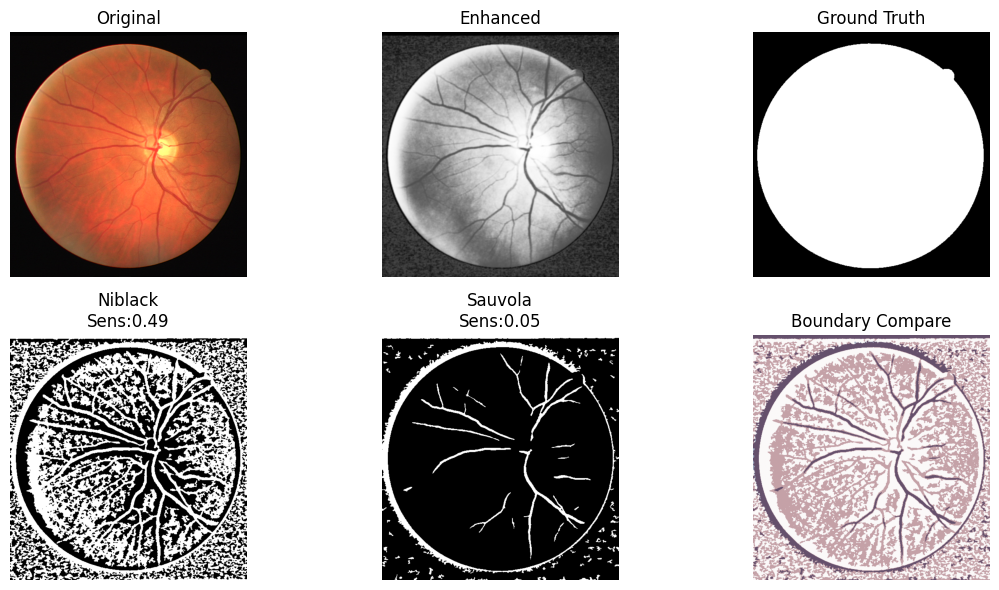

In [49]:
filename = image_files[3]

img, gt_mask = load_pair(filename)
green = preprocess(img)

niblack = niblack_segmentation(green)
sauvola = sauvola_segmentation(green)

# niblack = enhance_thin_vessels(niblack)
# sauvola = enhance_thin_vessels(sauvola)

sens_n, acc_n, f1_n = evaluate(niblack, gt_mask, fov)
sens_s, acc_s, f1_s = evaluate(sauvola, gt_mask, fov)

plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(green, cmap='gray')
plt.title("Enhanced")
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(niblack, cmap='gray')
plt.title(f"Niblack\nSens:{sens_n:.2f}")
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(sauvola, cmap='gray')
plt.title(f"Sauvola\nSens:{sens_s:.2f}")
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(niblack, cmap='Reds', alpha=0.6)
plt.imshow(sauvola, cmap='Blues', alpha=0.4)
plt.title("Boundary Compare")
plt.axis('off')

plt.tight_layout()
plt.show()

image at index 15

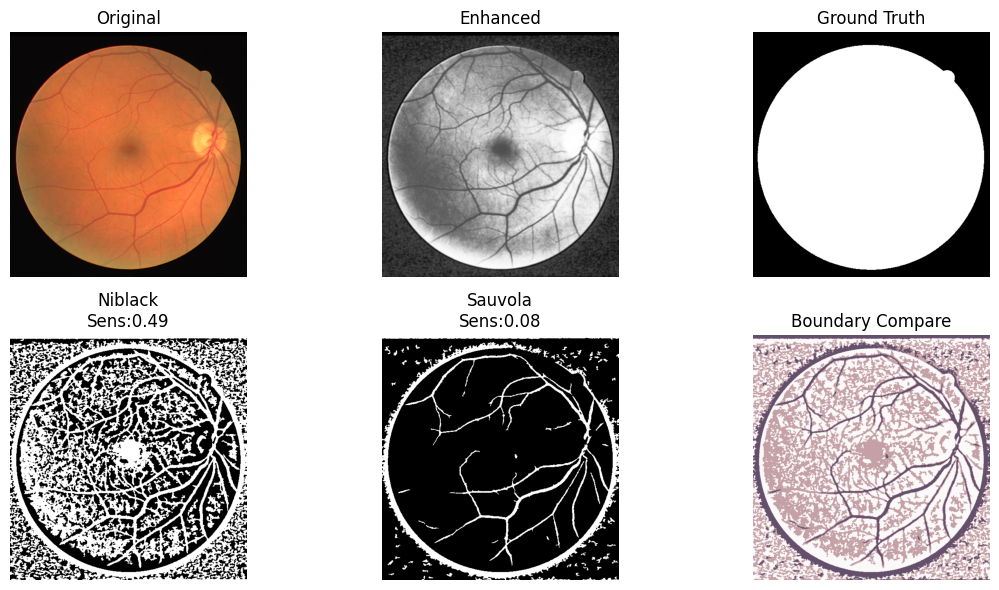

In [50]:
filename = image_files[15]

img, gt_mask = load_pair(filename)
green = preprocess(img)

niblack = niblack_segmentation(green)
sauvola = sauvola_segmentation(green)

# niblack = enhance_thin_vessels(niblack)
# sauvola = enhance_thin_vessels(sauvola)

sens_n, acc_n, f1_n = evaluate(niblack, gt_mask, fov)
sens_s, acc_s, f1_s = evaluate(sauvola, gt_mask, fov)

plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(green, cmap='gray')
plt.title("Enhanced")
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(niblack, cmap='gray')
plt.title(f"Niblack\nSens:{sens_n:.2f}")
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(sauvola, cmap='gray')
plt.title(f"Sauvola\nSens:{sens_s:.2f}")
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(niblack, cmap='Reds', alpha=0.6)
plt.imshow(sauvola, cmap='Blues', alpha=0.4)
plt.title("Boundary Compare")
plt.axis('off')

plt.tight_layout()
plt.show()

Evaluate Entire Test Dataset

In [51]:
sens_n_list, sens_s_list = [], []
acc_n_list, acc_s_list = [], []
f1_n_list, f1_s_list = [], []

for file in image_files:

    img, gt = load_pair(file)
    green = preprocess(img)

    # segmentation
    niblack = niblack_segmentation(green)
    sauvola = sauvola_segmentation(green)

    # compute FOV mask for THIS image
    fov = get_fov_mask(img)

    # evaluate
    sens_n, acc_n, f1_n = evaluate(niblack, gt, fov)
    sens_s, acc_s, f1_s = evaluate(sauvola, gt, fov)

    sens_n_list.append(sens_n)
    sens_s_list.append(sens_s)
    acc_n_list.append(acc_n)
    acc_s_list.append(acc_s)
    f1_n_list.append(f1_n)
    f1_s_list.append(f1_s)

print("===== FINAL RESULTS =====\n")

print("Niblack Sensitivity:", round(np.mean(sens_n_list),3))
print("Sauvola Sensitivity:", round(np.mean(sens_s_list),3))

print("\nNiblack Accuracy:", round(np.mean(acc_n_list),3))
print("Sauvola Accuracy:", round(np.mean(acc_s_list),3))

print("\nNiblack F1 Score:", round(np.mean(f1_n_list),3))
print("Sauvola F1 Score:", round(np.mean(f1_s_list),3))

===== FINAL RESULTS =====

Niblack Sensitivity: 0.491
Sauvola Sensitivity: 0.072

Niblack Accuracy: 0.488
Sauvola Accuracy: 0.073

Niblack F1 Score: 0.656
Sauvola F1 Score: 0.133


Conclusion

Niblack thresholding performed better, achieving higher sensitivity and F1-score, meaning it detected foreground pixels more accurately and balanced precision–recall well.

Sauvola performed poorly due to parameter sensitivity and the image’s uniform illumination, making Niblack more suitable for this case.